# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Lê Anh Duy
- MSSV: 23127011
- Lớp: 23CLC05

## Import các thư viện liên quan

In [2]:
!pip install matplotlib numpy pillow pandas

In [3]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


## Helper functions

In [4]:
def initialize_centroids_kmeanspp(data, k):
    '''
    Optimized K-Means++ initialization using vectorized NumPy.

    Parameters
    ----------
    data : np.ndarray, shape=(n_samples, n_features)
    k : int

    Returns
    -------
    centroids : np.ndarray, shape=(k, n_features)
    '''
    n_samples, _ = data.shape
    centroids = np.empty((k, data.shape[1]), dtype=data.dtype)

    # Step 1: randomly choose the first centroid
    idx = np.random.randint(n_samples)
    centroids[0] = data[idx]

    # Step 2: compute all remaining k-1 centroids
    distances = np.full(n_samples, np.inf)

    for i in range(1, k):
        # Compute squared distances to the nearest existing centroid
        new_distances = np.sum((data - centroids[i - 1]) ** 2, axis=1)
        distances = np.minimum(distances, new_distances)

        # Compute probabilities proportional to distance squared
        probabilities = distances / distances.sum()
        cumulative_probs = np.cumsum(probabilities)

        # Sample new centroid based on weighted probabilities
        r = np.random.rand()
        next_idx = np.searchsorted(cumulative_probs, r)
        centroids[i] = data[next_idx]

    return centroids


In [5]:
def initialize_centroids_maximin(data, k):
    '''
    Maximin centroid initialization for K-Means.

    Parameters
    ----------
    data : np.ndarray, shape=(n_samples, n_features)
        Input data to cluster.
    k : int
        Number of clusters.

    Returns
    -------
    centroids : np.ndarray, shape=(k, n_features)
        Initialized centroids.
    '''
    n_samples, n_features = data.shape
    centroids = np.empty((k, n_features), dtype=data.dtype)

    # Step 1: randomly choose the first centroid
    idx = np.random.randint(n_samples)
    centroids[0] = data[idx]

    for i in range(1, k):
        # Compute distance to the nearest existing centroid
        distances = np.min(
            np.linalg.norm(data[:, np.newaxis] - centroids[np.newaxis, :i], axis=2),
            axis=1
        )

        # Choose the point with the maximum distance to its closest centroid
        next_idx = np.argmax(distances)
        centroids[i] = data[next_idx]

    return centroids


In [6]:
global glo_number

In [7]:

def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''
    return Image.open(img_path)


def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : PIL.Image.Image
        Image (2D)
    '''
    plt.imshow(np.asarray(img_2d))
    plt.axis('off')
    plt.show()


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : PIL.Image.Image
        Image (2D)
    img_path : str
        Path of image
    '''
    img_2d.save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : PIL.Image.Image
        Image (2D)

    Returns
    -------
    np.ndarray
        Image (1D)
    '''
    img = np.asarray(img_2d)
    h, w, c = img.shape
    return img.reshape(-1, c)


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    np.random.seed(42)

    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, size=(k_clusters, img_1d.shape[1]))
    elif init_centroids == 'in_pixels':
        indices = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)
        centroids = img_1d[indices]
    elif init_centroids == 'kmeans++':
        centroids = initialize_centroids_kmeanspp(img_1d, k_clusters)
    elif init_centroids == 'maximin':
        centroids = initialize_centroids_maximin(img_1d, k_clusters)
    else:
        raise ValueError("init_centroids must be either 'random' or 'in_pixels' or 'kmeas++' or 'maximin'")

    number_itter = 0

    for _ in range(max_iter):
        number_itter += 1
        distances = np.linalg.norm(img_1d[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([img_1d[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k_clusters)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    global glo_number
    glo_number = number_itter
    print(f"Number of itteration with {init_centroids} {number_itter}")

    return centroids.astype(np.uint8), labels


def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple
        Shape of image (height, width, channels)
    centroids : np.ndarray
        Color centroids
    labels : np.ndarray
        Pixel labels

    Returns
    -------
    PIL.Image.Image
        New image (2D)
    '''
    height, width, channels = img_2d_shape
    img_1d = centroids[labels]
    img_2d = img_1d.reshape((height, width, channels))
    return Image.fromarray(img_2d.astype(np.uint8))


## Your tests

### 1. Testing strategy and fucntions

In this section, I will implement the functions for testing the color compression algorithm and fucntions for ploting the visualizations. The tests will cover various scenarios, including edge cases and typical use cases.

**The functions include:**
- `plot_clusters`: This function will visualize the clusters formed by the color compression algorithm.
- `plot_clusters_on_ax`: This function will plot the clusters on a given mathplotlib axis.
- `test_all`:  Runs K-Means color compression on an image using all four initialization methods, and saves a comparison image for each method. Each output image contains the compressed image and its corresponding cluster visualization plot side-by-side.
- `visualize_kmeans_range`: Visualizes the effect of different K values on K-Means color compression.
- `kmeans_with_convergence_plot`: This function runs K-Means color compression on an image and plots the convergence of the algorithm over iterations.


In [8]:
def plot_clusters(img_1d, labels, centroids, sample_size=1000):
    '''
    Visualize pixel clustering with centroid colors and pixel counts in legend.

    Parameters
    ----------
    img_1d : np.ndarray of shape (n_pixels, 3)
        Flattened RGB pixels.
    labels : np.ndarray of shape (n_pixels,)
        Cluster labels for each pixel.
    centroids : np.ndarray of shape (k, 3)
        RGB centroids (cluster colors).
    sample_size : int
        Max number of pixels to display for performance.
    '''
    n_samples = img_1d.shape[0]

    # Sampling
    if n_samples > sample_size:
        idx = np.random.choice(n_samples, sample_size, replace=False)
        data = img_1d[idx]
        lbls = labels[idx]
    else:
        data = img_1d
        lbls = labels

    # PCA projection to 2D
    mean = np.mean(data, axis=0)
    centered = data - mean
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
    projected_data = centered @ eigvecs[:, :2]

    # Project centroids
    centroids_centered = centroids - mean
    projected_centroids = centroids_centered @ eigvecs[:, :2]

    # Assign colors
    colors = centroids[lbls] / 255.0

    # Count pixels per cluster
    counts = np.bincount(labels, minlength=len(centroids))

    # Plot pixels
    plt.figure(figsize=(10, 8))
    plt.scatter(projected_data[:, 0], projected_data[:, 1],
                c=colors, s=5, alpha=0.7)

    # Plot centroids and prepare legend
    legend_elements = []
    for i, (cx, cy) in enumerate(projected_centroids):
        color = centroids[i] / 255.0
        plt.scatter(cx, cy, color=color, edgecolors='black',
                    marker='o', s=200)
        
        # Add to legend with pixel count
        label_str = f"Cluster {i} — {counts[i]} px"
        legend_elements.append(Patch(facecolor=color, edgecolor='black', label=label_str))

    # Show legend
    plt.legend(handles=legend_elements, title="Clusters", loc="best")

    # Labels and layout
    plt.title("Pixel Clustering with PCA Projection and Pixel Count per Cluster")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_clusters_on_ax(ax, img_1d, labels, centroids, sample_size=1000):
    '''
    Visualize pixel clustering on a given matplotlib axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The subplot to draw on.
    img_1d : np.ndarray of shape (n_pixels, 3)
        Flattened RGB pixels.
    labels : np.ndarray of shape (n_pixels,)
        Cluster labels for each pixel.
    centroids : np.ndarray of shape (k, 3)
        RGB centroids (cluster colors).
    sample_size : int
        Max number of pixels to display for performance.
    '''
    n_samples = img_1d.shape[0]

    # Sampling
    if n_samples > sample_size:
        idx = np.random.choice(n_samples, sample_size, replace=False)
        data = img_1d[idx]
        lbls = labels[idx]
    else:
        data = img_1d
        lbls = labels

    # PCA projection to 2D
    mean = np.mean(data, axis=0)
    centered = data - mean
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
    projected_data = centered @ eigvecs[:, :2]

    # Project centroids
    centroids_centered = centroids - mean
    projected_centroids = centroids_centered @ eigvecs[:, :2]

    # Assign colors
    colors = centroids[lbls] / 255.0

    # Count pixels per cluster
    counts = np.bincount(labels, minlength=len(centroids))

    # Plot pixels
    ax.scatter(projected_data[:, 0], projected_data[:, 1],
               c=colors, s=5, alpha=0.7)

    # Plot centroids and prepare legend
    legend_elements = []
    for i, (cx, cy) in enumerate(projected_centroids):
        color = centroids[i] / 255.0
        ax.scatter(cx, cy, color=color, edgecolors='black',
                   marker='o', s=200)
        
        # Add to legend with pixel count
        label_str = f"Cluster {i} — {counts[i]} px"
        legend_elements.append(Patch(facecolor=color, edgecolor='black', label=label_str))

    # Show legend
    ax.legend(handles=legend_elements, title="Clusters", loc="best")

    # Labels and layout
    ax.set_title("PCA Projection of Pixel Clusters")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.grid(True)


In [9]:
def test_all(img_path, k_clusters=7, max_iter=100):
    """
    Runs K-Means color compression on an image using all four initialization methods,
    and saves a comparison image for each method.

    Each output image contains the compressed image and its corresponding
    cluster visualization plot side-by-side.

    Parameters
    ----------
    img_path : str
        The path to the input image.
    k_clusters : int, optional
        Number of clusters for K-Means, by default 7.
    max_iter : int, optional
        Maximum number of iterations for K-Means, by default 100.
    """
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at '{img_path}'")
        return

    # 1. Load and prepare image data once
    print(f"Loading image: {img_path}")
    img = read_img(img_path)

    

    img_1d = convert_img_to_1d(img)
    img_shape = np.asarray(img).shape

    init_methods = ['random', 'in_pixels', 'kmeans++', 'maximin']
    
    # Lấy tên file gốc để đặt tên cho file output
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # 2. Loop through each initialization method

    original_colors = len(np.unique(img_1d, axis=0))
    summary = []

    for i, method in enumerate(init_methods):
        print(f"\n--- Processing with method: '{method}' ---")
        
        # Run K-Means
        centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids=method)
        
        # Generate the compressed image
        new_img = generate_2d_img(img_shape, centroids, labels)
        
        # 3. Create a figure with two subplots (side-by-side)
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # --- Left Subplot: Compressed Image ---
        axes[0].imshow(new_img)
        axes[0].set_title(f"Compressed Image ({method})")
        axes[0].axis('off')
        
        # --- Right Subplot: Cluster Visualization ---
        # Use the modified plotting function
        plot_clusters_on_ax(axes[1], img_1d, labels, centroids)
        
        unique_colors = len(np.unique(centroids, axis=0))
        compression_ratio = round(original_colors / unique_colors, 2)
        global glo_number
        # Add an overall title
        fig.suptitle(f"Color Compression using K-Means with '{method.upper()}' Initialization", fontsize=16)
        summary.append({
            'Init Method': method,
            f'Iterations over {max_iter}': glo_number,
            'Original Colors': original_colors,
            'Compressed Colors': unique_colors,
            'Compression Ratio': compression_ratio
        })
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        
        # 4. Save the combined figure
        output_filename = f"{base_name}_output_{i+1}_{method}.png"
        plt.savefig(output_filename)
        print(f"Saved comparison to '{output_filename}'")
        
        # Show the plot in the notebook (optional)
        plt.show()

    
    df = pd.DataFrame(summary)
    print("\n### Summary of K-Means Results:\n")
    print(df.to_markdown(index=False)) 

In [10]:
def visualize_kmeans_range(min_k, max_k, step, img_path, init_method='kmeans++', max_iter=100):
    """
    Visualizes the effect of different K values on K-Means color compression.

    Parameters
    ----------
    min_k : int
        Minimum number of clusters.
    max_k : int
        Maximum number of clusters.
    img_path : str
        Path to the input image.
    init_method : str, optional
        Initialization method for K-Means. Default is 'kmeans++'.
    max_iter : int, optional
        Maximum number of iterations for K-Means.
    """
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at '{img_path}'")
        return

    img = read_img(img_path)
    img_1d = convert_img_to_1d(img)
    img_shape = np.asarray(img).shape
    original_colors = len(np.unique(img_1d, axis=0))

    # Determine the number of K values to plot
    k_values = list(range(min_k, max_k + 1, step))
    num_k = len(k_values)

    # Create a grid of subplots
    cols = 3  # Adjust for layout preference
    rows = math.ceil(num_k / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    summary = []

    for idx, k in enumerate(k_values):
        print(f"Running K-Means with k={k}")
        centroids, labels = kmeans(img_1d, k, max_iter, init_centroids=init_method)
        new_img = generate_2d_img(img_shape, centroids, labels)

        unique_colors = len(np.unique(centroids, axis=0))
        compression_ratio = round(original_colors / unique_colors, 2)

        # Plot compressed image
        axes[idx].imshow(new_img)
        axes[idx].set_title(f"k={k} | Ratio={compression_ratio}", fontsize=12)
        axes[idx].axis('off')

        summary.append({
            'k': k,
            'Original Colors': original_colors,
            'Compressed Colors': unique_colors,
            'Compression Ratio': compression_ratio
        })

    # Hide extra subplots (if any)
    for j in range(num_k, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"K-Means Color Compression ({init_method.upper()}) from k={min_k} to k={max_k}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Optional: Display summary
    df = pd.DataFrame(summary)
    print("\n### Summary of Results:\n")
    print(df.to_markdown(index=False))


In [11]:

def plot_sorted_image_by_color_distance(img_1d, img_shape, sort_by='luminance', save_path=None, title='Sorted Color Transition'):
    """
    Sort all the pixels base on their color features and display the image after sorting
    Parameters
    ----------
    img_1d : np.ndarray
    img_shape : tuple
        Initial shape of the image: (height, width, channels)
    sort_by : str, optional
        ('luminance', 'red', 'green', 'blue')
    save_path : str, optional
    title : str
        title of the image
    """

    if sort_by == 'luminance':
        """
            The luminance conversion uses Rec. 709 luma coefficients:
            Y=0.2126*R + 0.7152*G + 0.0722*B
            (ITU-R BT.709)
        """
        sort_values = 0.2126 * img_1d[:, 0] + 0.7152 * img_1d[:, 1] + 0.0722 * img_1d[:, 2]
    elif sort_by == 'red':
        sort_values = img_1d[:, 0]
    elif sort_by == 'green':
        sort_values = img_1d[:, 1]
    elif sort_by == 'blue':
        sort_values = img_1d[:, 2]
    else:
        raise ValueError("sort_by must be one of ['luminance', 'red', 'green', 'blue']")

    sorted_idx = np.argsort(sort_values)
    sorted_pixels = img_1d[sorted_idx]

    # Reshape lại thành hình ảnh mới
    height, width, channels = img_shape
    sorted_img = sorted_pixels.reshape((height, width, channels))

    # Hiển thị
    plt.figure(figsize=(8, 6))
    plt.imshow(sorted_img.astype(np.uint8))
    plt.axis('off')
    plt.title(title)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
def sorted_image_by_color_distance(img_1d, img_shape, sort_by='luminance', save_path=None, title='Sorted Color Transition'):
    if sort_by == 'luminance':
        """
            The luminance conversion uses Rec. 709 luma coefficients:
            Y=0.2126*R + 0.7152*G + 0.0722*B
            (ITU-R BT.709)
        """
        sort_values = 0.2126 * img_1d[:, 0] + 0.7152 * img_1d[:, 1] + 0.0722 * img_1d[:, 2]
    elif sort_by == 'red':
        sort_values = img_1d[:, 0]
    elif sort_by == 'green':
        sort_values = img_1d[:, 1]
    elif sort_by == 'blue':
        sort_values = img_1d[:, 2]
    else:
        raise ValueError("sort_by must be one of ['luminance', 'red', 'green', 'blue']")

    sorted_idx = np.argsort(sort_values)
    sorted_pixels = img_1d[sorted_idx]

    # Reshape lại thành hình ảnh mới
    height, width, channels = img_shape
    sorted_img = sorted_pixels.reshape((height, width, channels))
    return sorted_img

In [ ]:


def kmeans_with_convergence_plot(img_1d, k_clusters, max_iter=100, init_centroids='random'):
    """
    K-Means algorithm with convergence tracking and plotting.

    Returns:
    - centroids: final color centroids
    - labels: label for each pixel
    - deltas: list of centroid movement (distance) per iteration
    """
    np.random.seed(42)

    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, size=(k_clusters, img_1d.shape[1]))
    elif init_centroids == 'in_pixels':
        indices = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)
        centroids = img_1d[indices]
    elif init_centroids == 'kmeans++':
        centroids = initialize_centroids_kmeanspp(img_1d, k_clusters)
    elif init_centroids == 'maximin':
        centroids = initialize_centroids_maximin(img_1d, k_clusters)
    else:
        raise ValueError("Unknown init_centroids method.")

    deltas = []  # Store centroid movement per iteration
    number_iter = 0

    for i in range(max_iter):
        number_iter += 1
        distances = np.linalg.norm(img_1d[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            img_1d[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k_clusters)
        ])

        delta = np.linalg.norm(new_centroids - centroids)
        deltas.append(delta)

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    # Plot convergence
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(deltas) + 1), deltas, marker='o')
    plt.title(f'Convergence Plot (Init = {init_centroids})')
    plt.xlabel('Iteration')
    plt.ylabel('Centroid Shift (Δ)')
    plt.grid(True)
    plt.show()

    return centroids.astype(np.uint8), labels, deltas


### 2. Run the tests

#### Read an image and compress it using K-Means color compression with a specfic initialization method

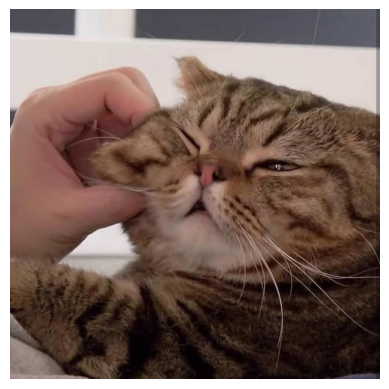

Number of itteration with maximin 10


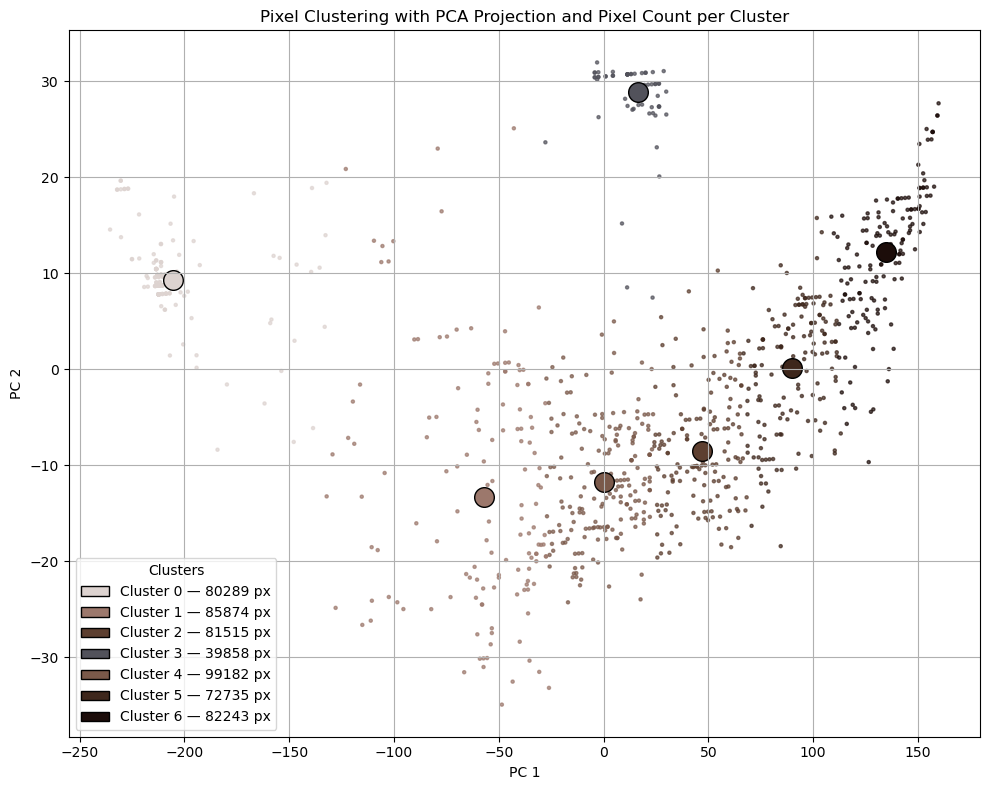

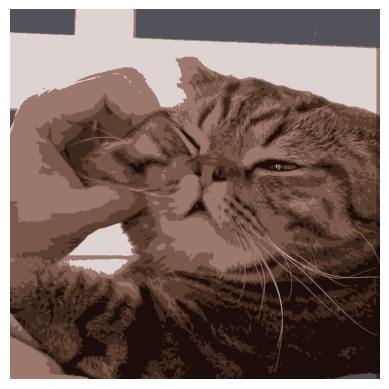

In [12]:
img = read_img("assets/cat.png")
show_img(img)

img_1d = convert_img_to_1d(img)
centroids, labels = kmeans(img_1d, k_clusters=7, max_iter=10, init_centroids='maximin')
new_img = generate_2d_img(np.asarray(img).shape, centroids, labels)
plot_clusters(img_1d, labels, centroids)

show_img(new_img)
save_img(new_img, "output.jpg")

In [13]:

# test_all("assets/cat.png", k_clusters=7, max_iter=100)

#### Visualiza the changes with the image as k increases

Running K-Means with k=3
Number of itteration with maximin 17
Running K-Means with k=5
Number of itteration with maximin 23
Running K-Means with k=7
Number of itteration with maximin 68


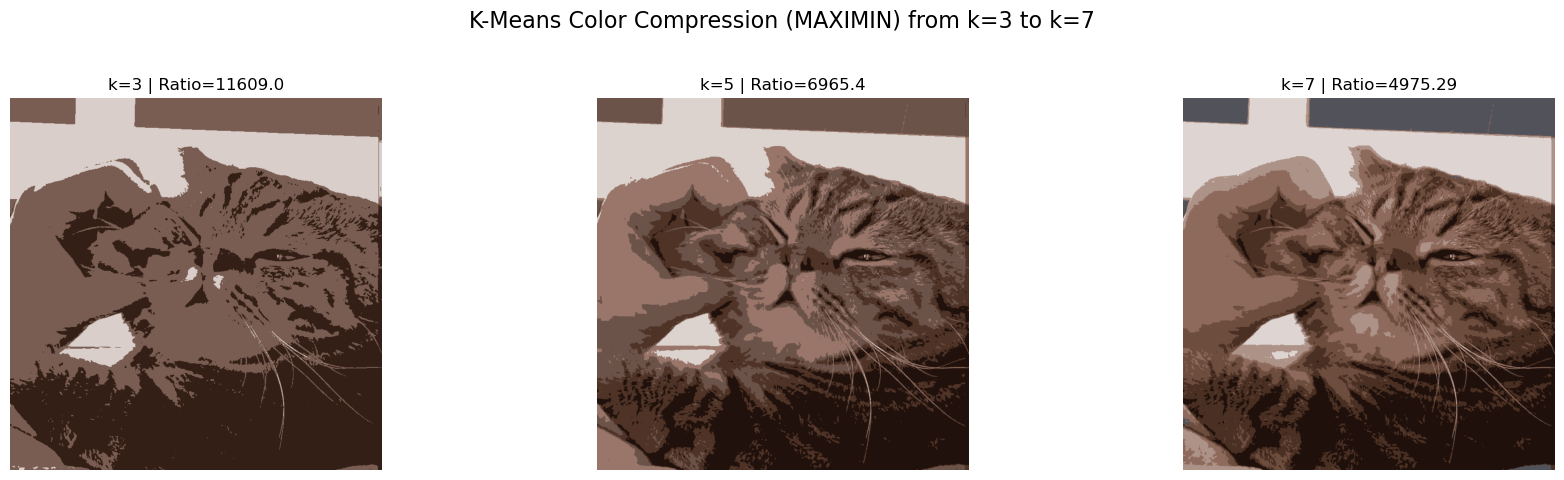


### Summary of Results:

|   k |   Original Colors |   Compressed Colors |   Compression Ratio |
|----:|------------------:|--------------------:|--------------------:|
|   3 |             34827 |                   3 |            11609    |
|   5 |             34827 |                   5 |             6965.4  |
|   7 |             34827 |                   7 |             4975.29 |


In [14]:
visualize_kmeans_range(3, 7, 2, 'assets/cat.png', init_method='maximin')

#### Test with image with small number of colors

Loading image: assets/flat-design.png

--- Processing with method: 'random' ---
Number of itteration with random 5
Saved comparison to 'flat-design_output_1_random.png'


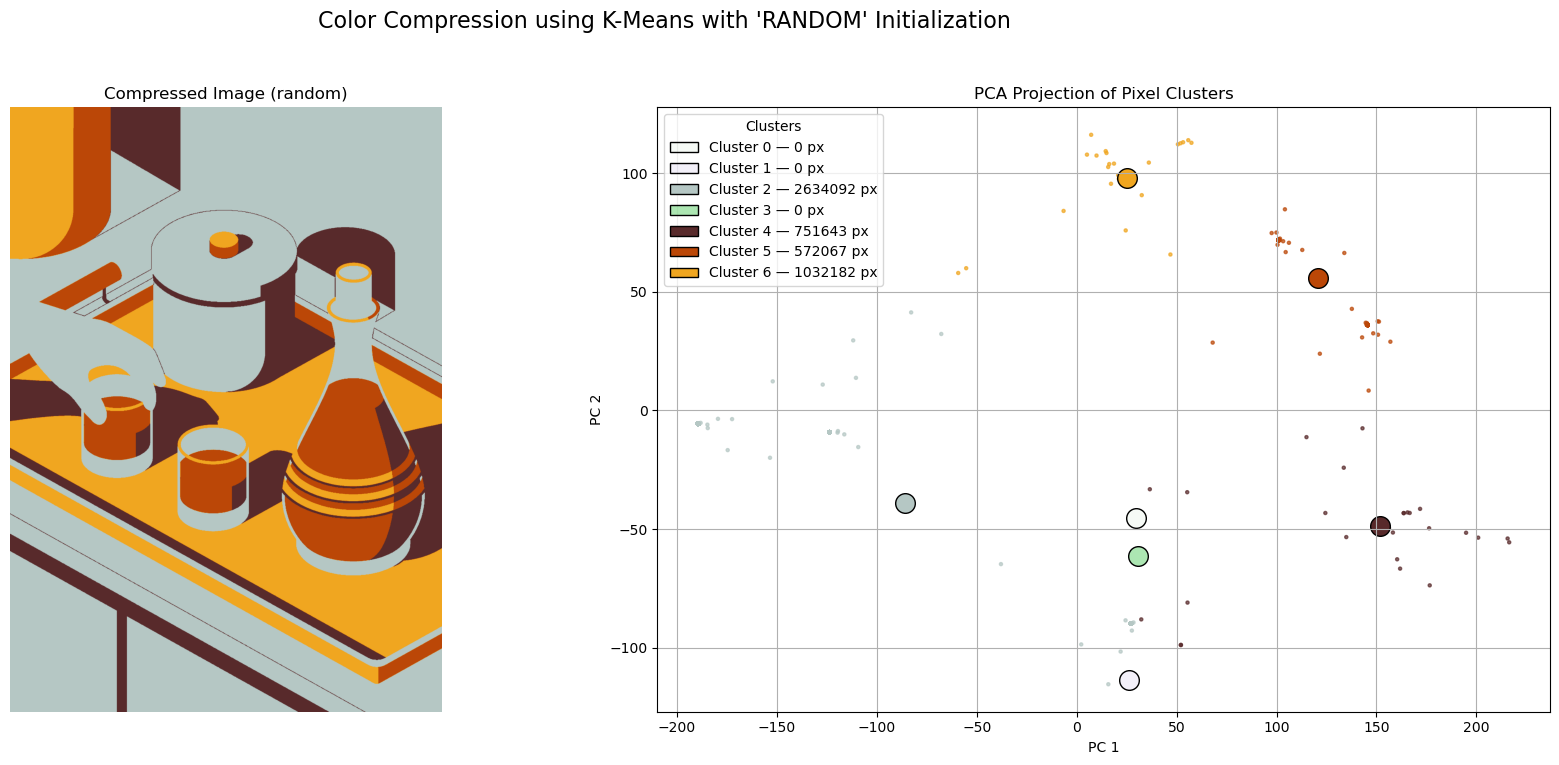


--- Processing with method: 'in_pixels' ---
Number of itteration with in_pixels 5
Saved comparison to 'flat-design_output_2_in_pixels.png'


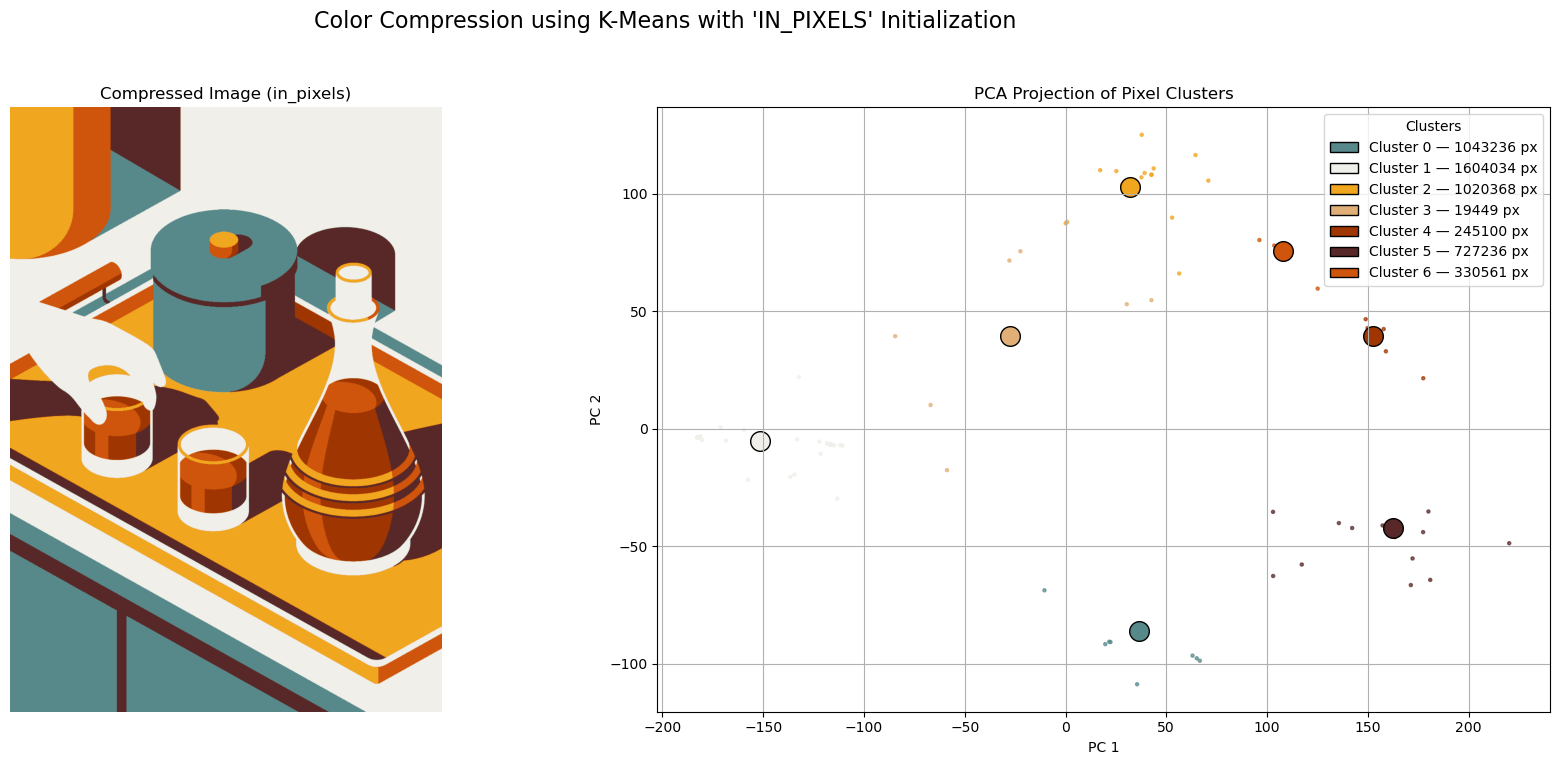


--- Processing with method: 'kmeans++' ---
Number of itteration with kmeans++ 5
Saved comparison to 'flat-design_output_3_kmeans++.png'


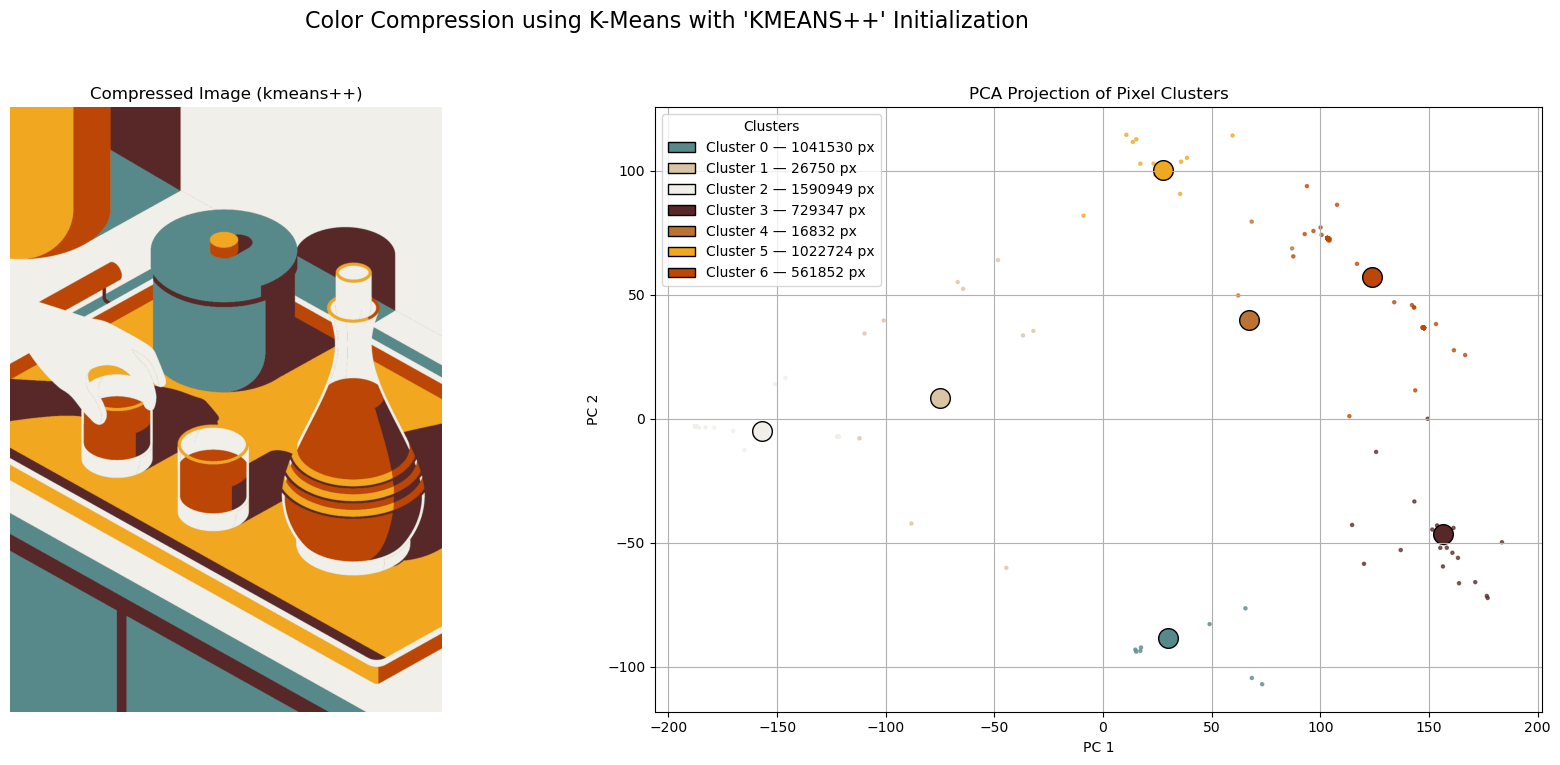


--- Processing with method: 'maximin' ---
Number of itteration with maximin 5
Saved comparison to 'flat-design_output_4_maximin.png'


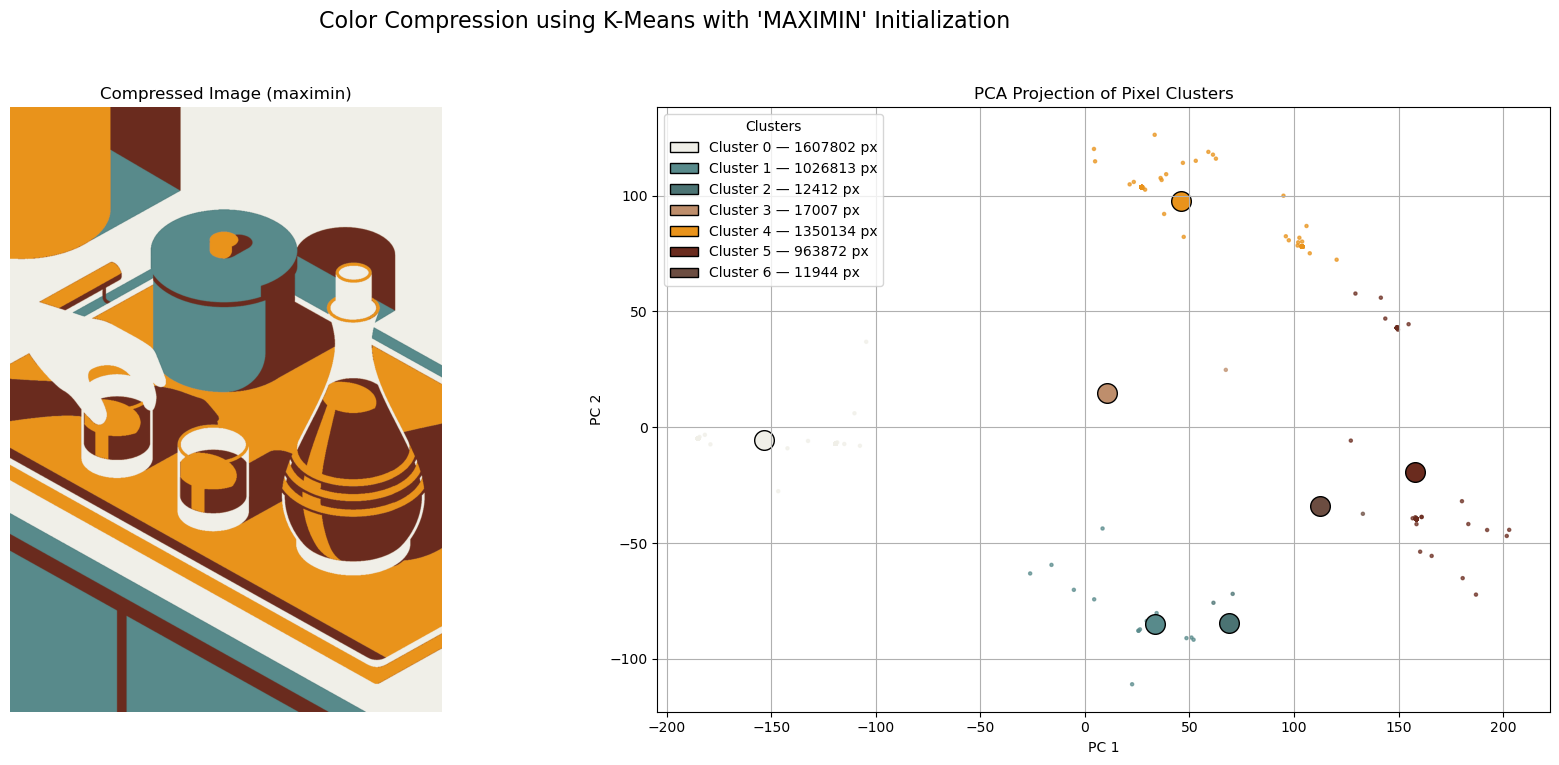


### Summary of K-Means Results:

| Init Method   |   Iterations over 5 |   Original Colors |   Compressed Colors |   Compression Ratio |
|:--------------|--------------------:|------------------:|--------------------:|--------------------:|
| random        |                   5 |             42524 |                   7 |             6074.86 |
| in_pixels     |                   5 |             42524 |                   7 |             6074.86 |
| kmeans++      |                   5 |             42524 |                   7 |             6074.86 |
| maximin       |                   5 |             42524 |                   7 |             6074.86 |


In [15]:

test_all("assets/flat-design.png", k_clusters=7, max_iter=5)

#### Test with image with large number of colors
Because the image is large, it will take a long time to run the K-Means algorithm. Therefore, I will limit the number of itterations in this notebook to 5 iterations for faster testing. In practice, you can increase the number of iterations to see the convergence of the algorithm.

Loading image: assets/landscape.jpg

--- Processing with method: 'random' ---
Number of itteration with random 5
Saved comparison to 'landscape_output_1_random.png'


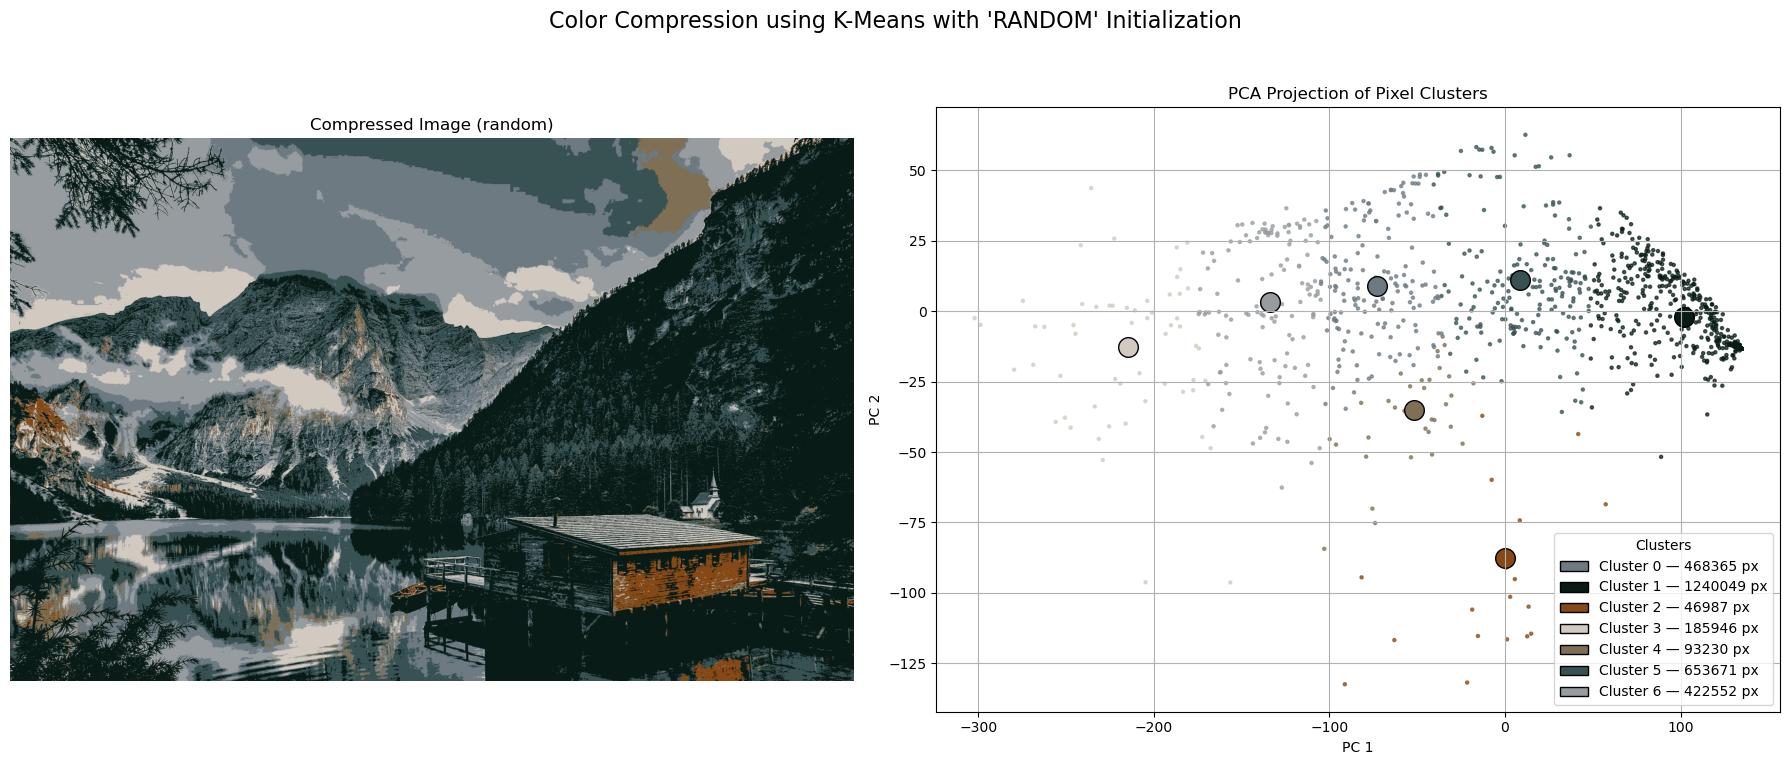


--- Processing with method: 'in_pixels' ---
Number of itteration with in_pixels 5
Saved comparison to 'landscape_output_2_in_pixels.png'


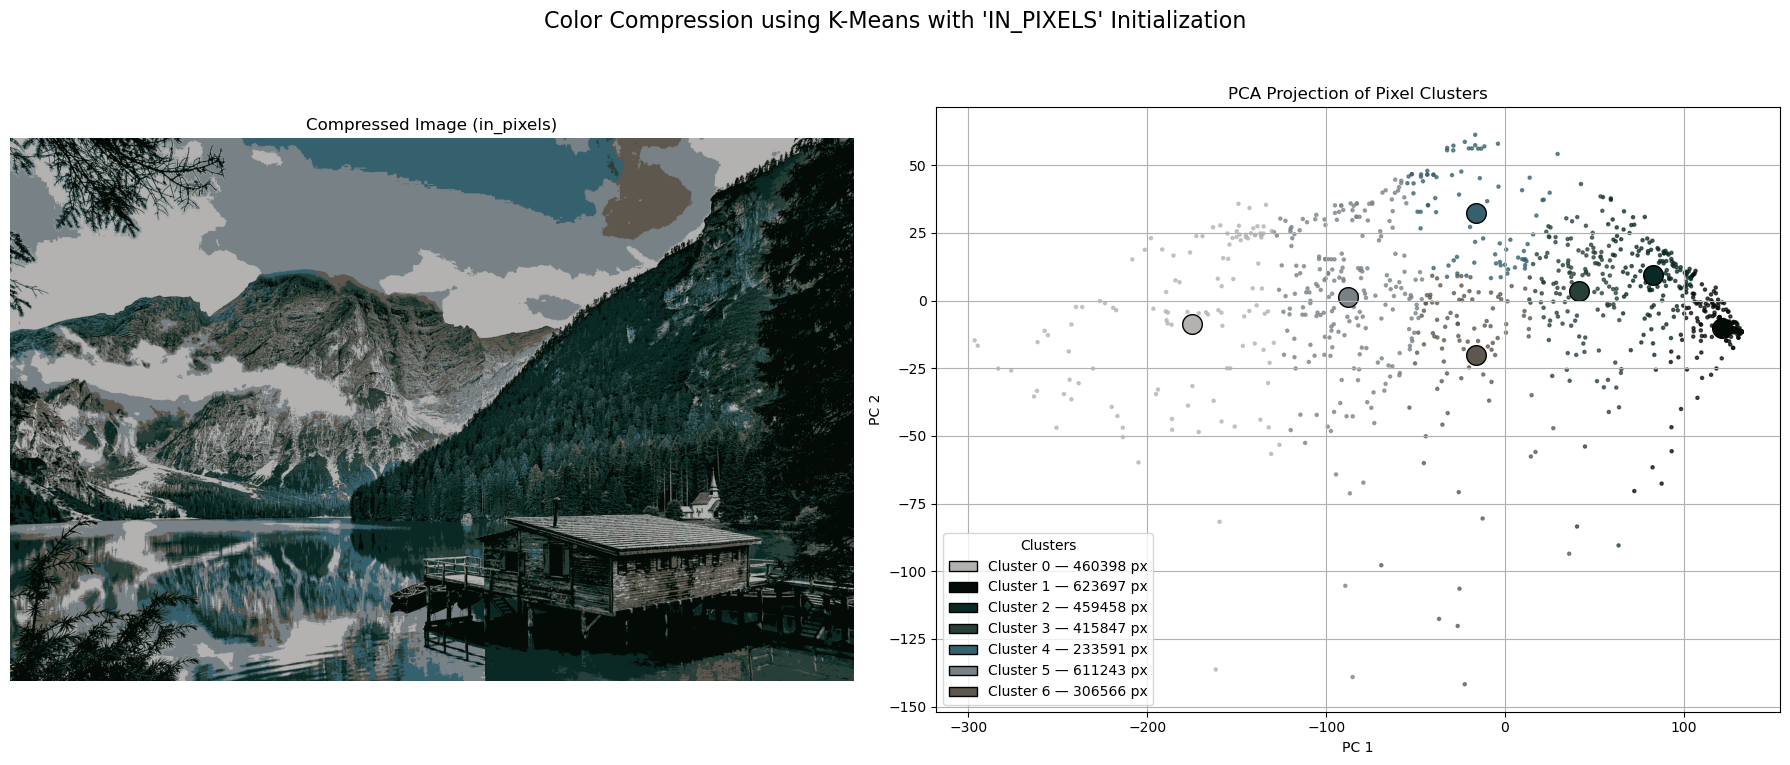


--- Processing with method: 'kmeans++' ---
Number of itteration with kmeans++ 5
Saved comparison to 'landscape_output_3_kmeans++.png'


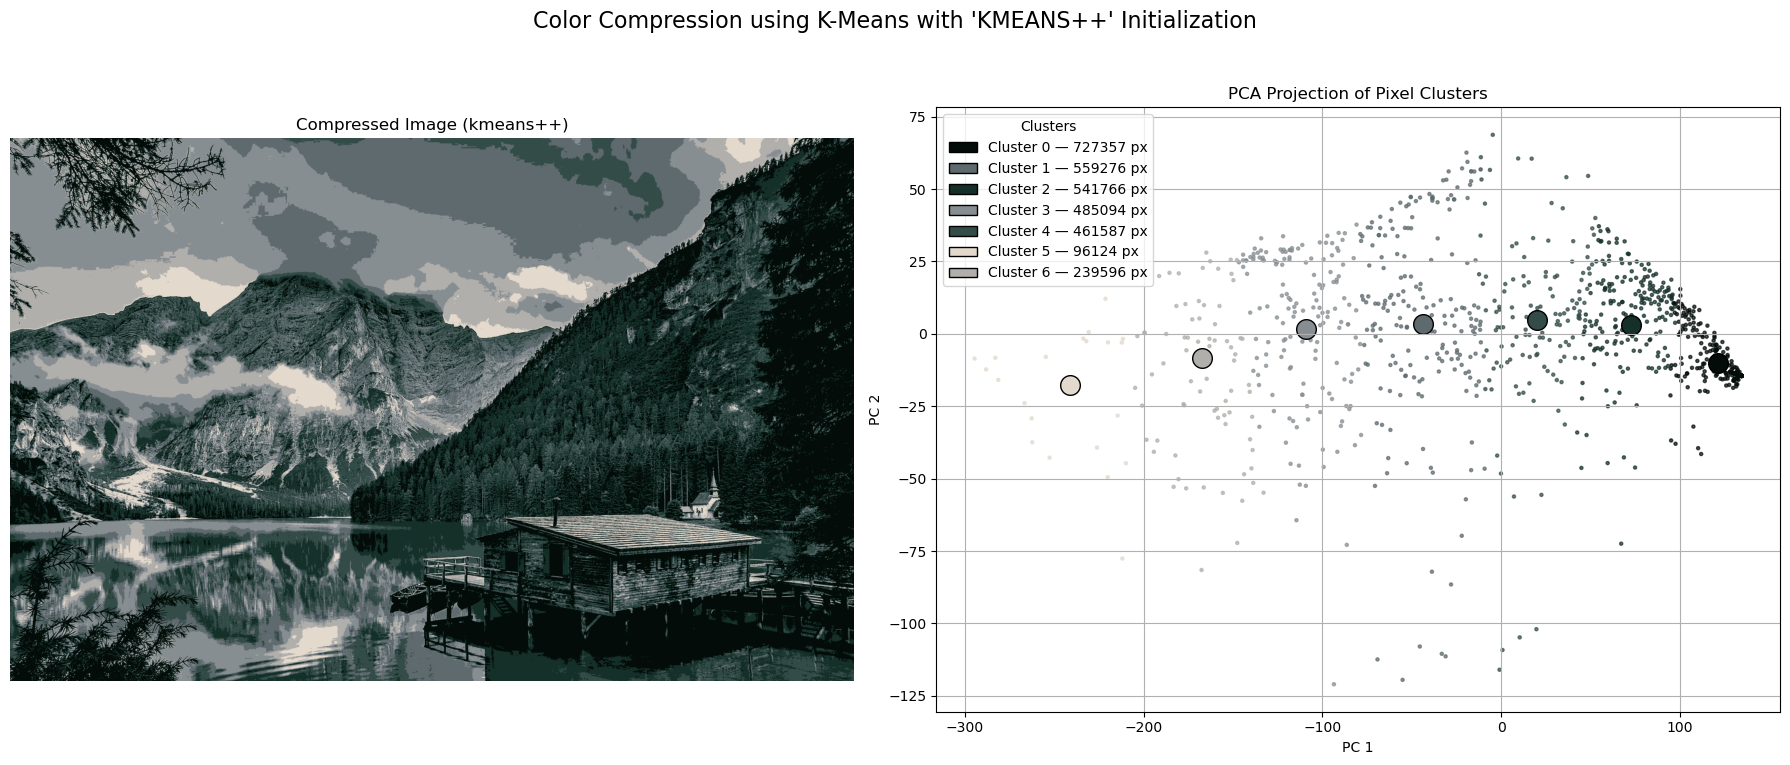


--- Processing with method: 'maximin' ---
Number of itteration with maximin 5
Saved comparison to 'landscape_output_4_maximin.png'


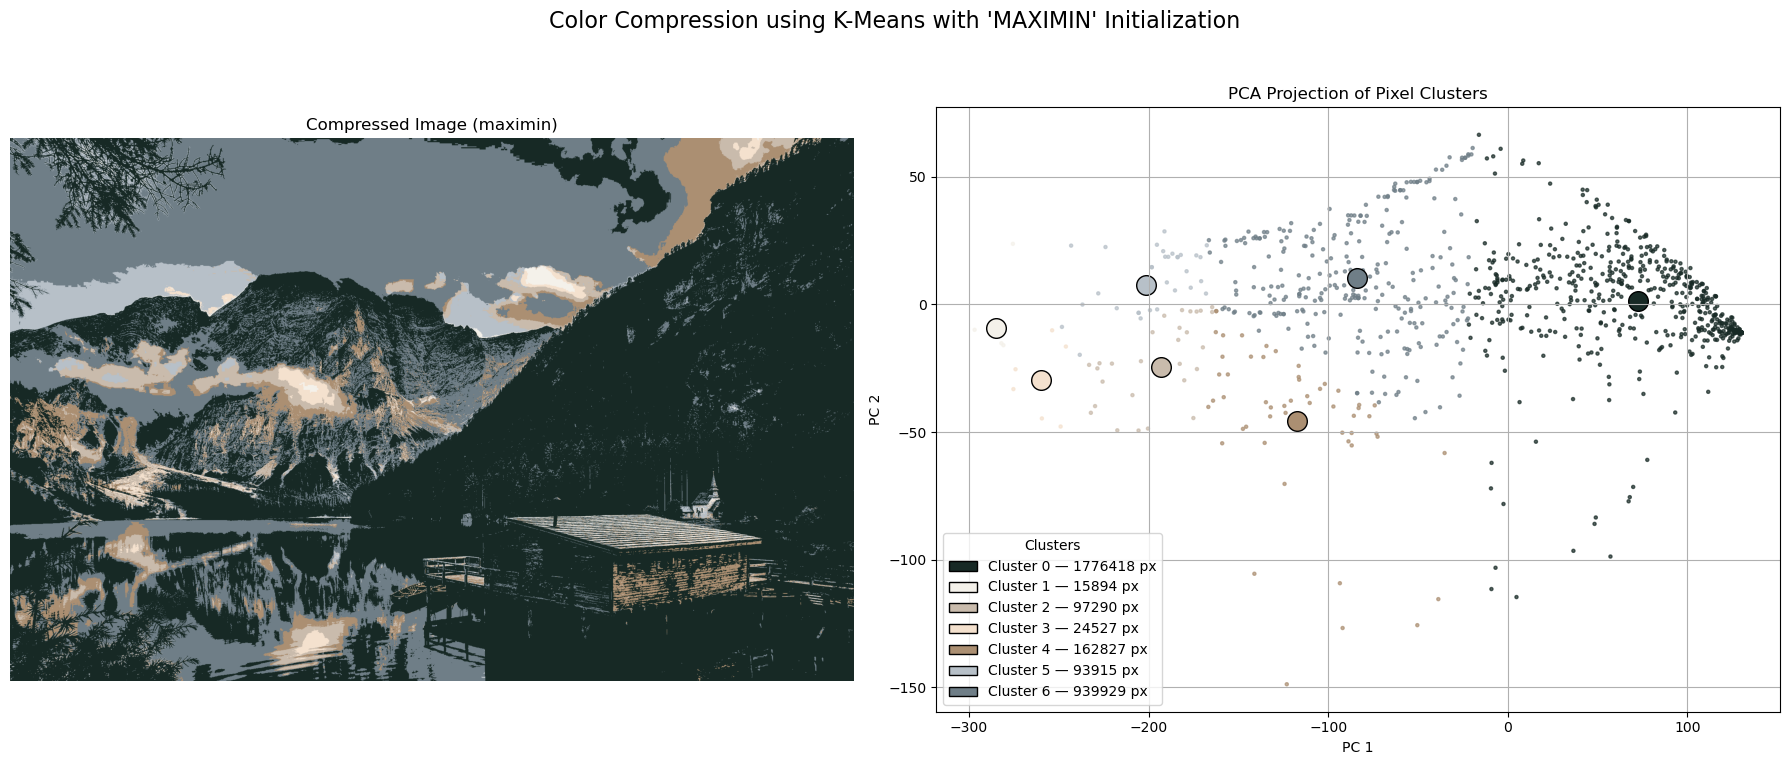


### Summary of K-Means Results:

| Init Method   |   Iterations over 5 |   Original Colors |   Compressed Colors |   Compression Ratio |
|:--------------|--------------------:|------------------:|--------------------:|--------------------:|
| random        |                   5 |            283684 |                   7 |             40526.3 |
| in_pixels     |                   5 |            283684 |                   7 |             40526.3 |
| kmeans++      |                   5 |            283684 |                   7 |             40526.3 |
| maximin       |                   5 |            283684 |                   7 |             40526.3 |


In [16]:
test_all("assets/landscape.jpg", k_clusters=7, max_iter=5)


#### Testing Visual Assessment Of the image

In [17]:

# img = read_img("assets/landscape-small.png")
# show_img(img)

# img_1d_origin = convert_img_to_1d(img)
# img_shape = np.asarray(img).shape

# # Hiển thị ảnh gốc được sắp xếp theo độ sáng
# print("Before compression")
# plot_sorted_image_by_color_distance(img_1d_origin, img_shape, sort_by='luminance', title='Original Image (Sorted by Brightness)')

# # Chuẩn bị figure với subplot
# ks = list(range(5, 12, 2))  # [5, 7, 9]
# n = len(ks)
# fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))  # Mỗi ảnh có kích thước khoảng 5x5 inch

# for ax, k in zip(axes, ks):
#     centroids, labels = kmeans(img_1d_origin, k_clusters=k, max_iter=100, init_centroids='in_pixels')
#     new_img = generate_2d_img(img_shape, centroids, labels)
#     img_1d = convert_img_to_1d(new_img)
#     reshaped_shape = new_img.size[1], new_img.size[0], 3  # (height, width, channels)

#     # Tính toán độ sáng và sắp xếp pixel
#     sorted_img = sorted_image_by_color_distance(img_1d, reshaped_shape, sort_by='luminance')
    
#     # Hiển thị ảnh đã sắp xếp
#     ax.imshow(sorted_img)
#     ax.set_title(f'k = {k}')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

#### Test with portrait image

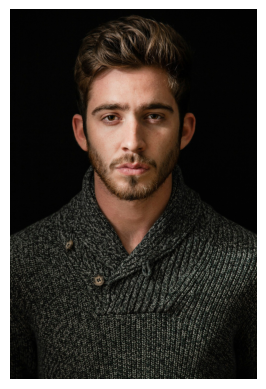

Before compression


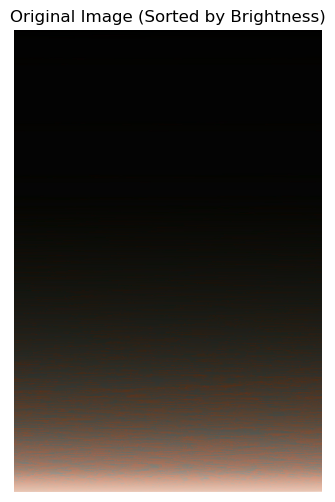

Number of itteration with in_pixels 47
Number of itteration with in_pixels 97
Number of itteration with in_pixels 100
Number of itteration with in_pixels 100


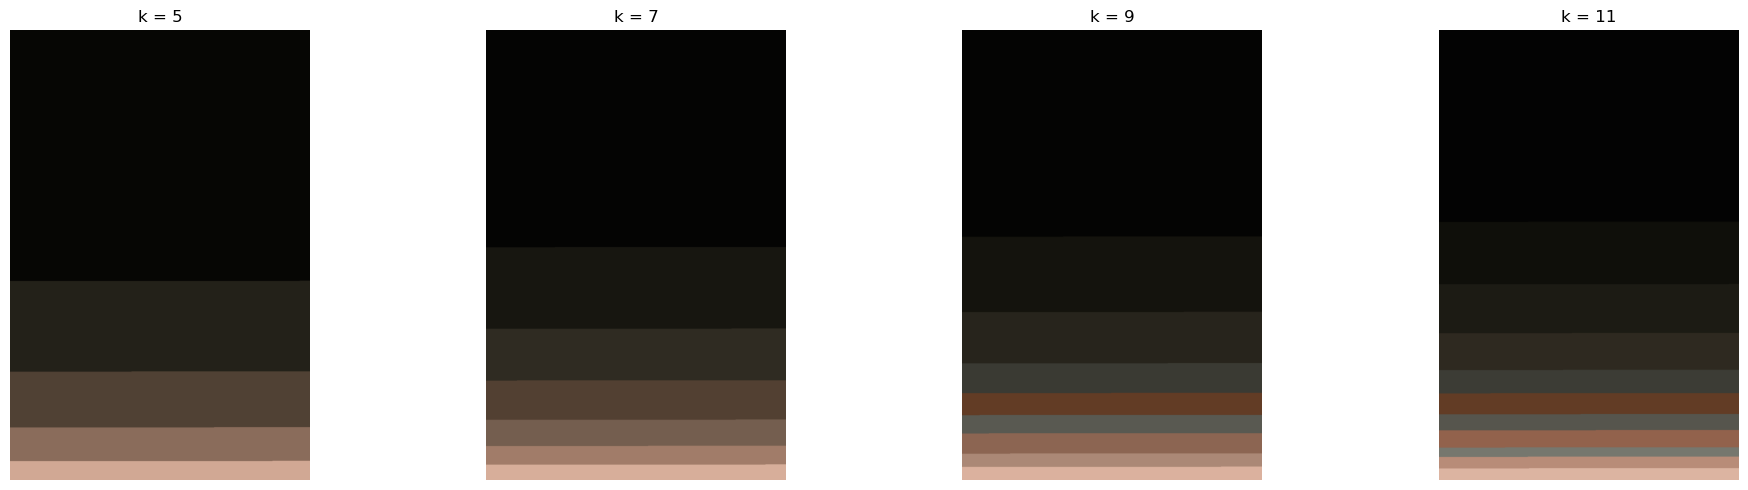

In [18]:

img = read_img("assets/portrait-resize.jpg")
show_img(img)

img_1d_origin = convert_img_to_1d(img)
img_shape = np.asarray(img).shape

# Hiển thị ảnh gốc được sắp xếp theo độ sáng
print("Before compression")
plot_sorted_image_by_color_distance(img_1d_origin, img_shape, sort_by='luminance', title='Original Image (Sorted by Brightness)')

# Chuẩn bị figure với subplot
ks = list(range(5, 12, 2))  # [5, 7, 9]
n = len(ks)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))  # Mỗi ảnh có kích thước khoảng 5x5 inch

for ax, k in zip(axes, ks):
    centroids, labels = kmeans(img_1d_origin, k_clusters=k, max_iter=100, init_centroids='in_pixels')
    new_img = generate_2d_img(img_shape, centroids, labels)
    img_1d = convert_img_to_1d(new_img)
    reshaped_shape = new_img.size[1], new_img.size[0], 3  # (height, width, channels)

    # Tính toán độ sáng và sắp xếp pixel
    sorted_img = sorted_image_by_color_distance(img_1d, reshaped_shape, sort_by='luminance')
    
    # Hiển thị ảnh đã sắp xếp
    ax.imshow(sorted_img)
    ax.set_title(f'k = {k}')
    ax.axis('off')

plt.tight_layout()
plt.show()

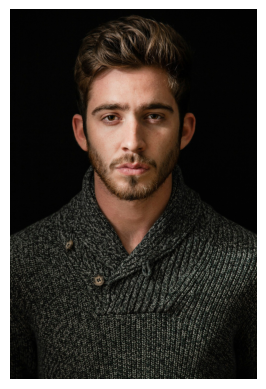

Before compression


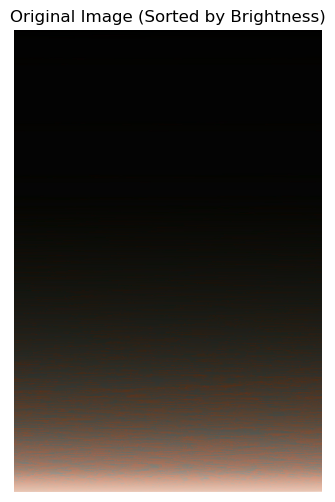

Number of itteration with in_pixels 47
Number of itteration with in_pixels 97
Number of itteration with in_pixels 100
Number of itteration with in_pixels 100


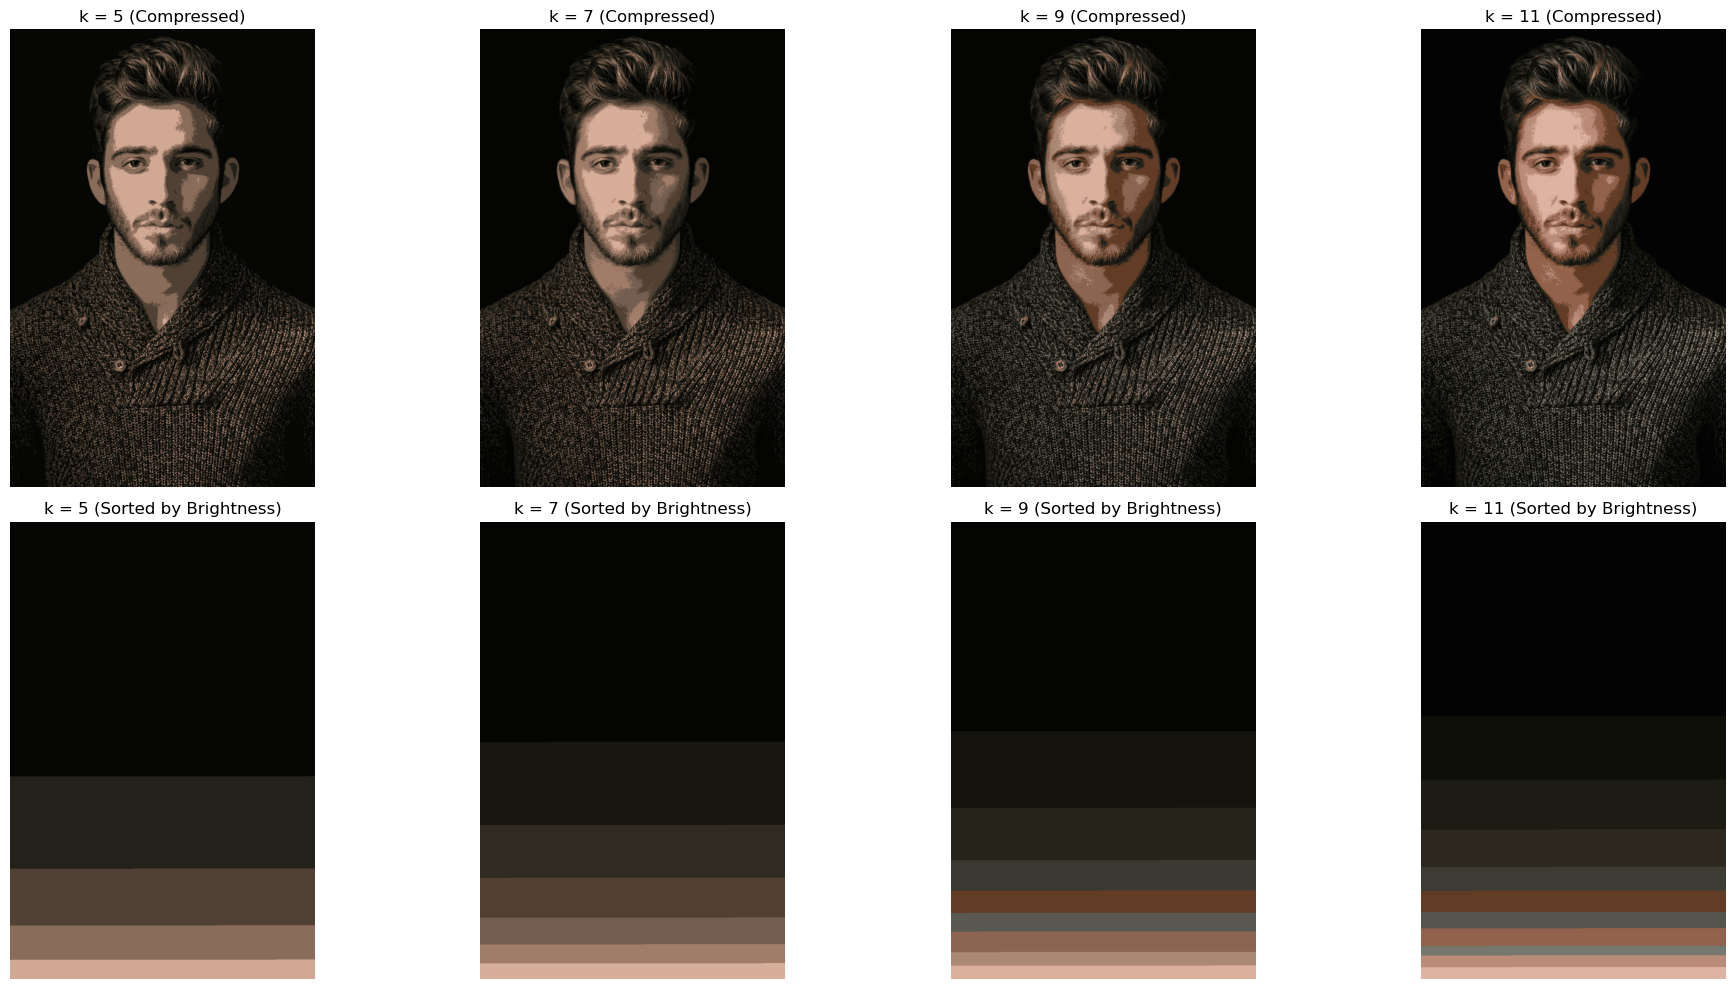

In [21]:
img = read_img("assets/portrait-resize.jpg")
show_img(img)

img_1d_origin = convert_img_to_1d(img)
img_shape = np.asarray(img).shape

# Hiển thị ảnh gốc được sắp xếp theo độ sáng
print("Before compression")
plot_sorted_image_by_color_distance(img_1d_origin, img_shape, sort_by='luminance', title='Original Image (Sorted by Brightness)')

# Các giá trị k
ks = list(range(5, 12, 2))  # [5, 7, 9]
n = len(ks)

# Tạo figure với 2 hàng và n cột
fig, axes = plt.subplots(2, n, figsize=(5 * n, 10))  # mỗi cột là một k, có 2 hàng

for i, k in enumerate(ks):
    # Áp dụng k-means
    centroids, labels = kmeans(img_1d_origin, k_clusters=k, max_iter=100, init_centroids='in_pixels')
    new_img = generate_2d_img(img_shape, centroids, labels)
    
    # Chuyển đổi ảnh nén thành 1D để sắp xếp
    img_1d = convert_img_to_1d(new_img)
    reshaped_shape = new_img.size[1], new_img.size[0], 3  # (height, width, channels)

    # Ảnh đã sắp xếp
    sorted_img = sorted_image_by_color_distance(img_1d, reshaped_shape, sort_by='luminance')

    # Hiển thị ảnh nén ở hàng trên
    axes[0, i].imshow(new_img)
    axes[0, i].set_title(f'k = {k} (Compressed)')
    axes[0, i].axis('off')

    # Hiển thị ảnh đã sắp xếp ở hàng dưới
    axes[1, i].imshow(sorted_img)
    axes[1, i].set_title(f'k = {k} (Sorted by Brightness)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## Main FUNCTION

The main fucntion will run the color compression algorithm on a given image using the specified number of clusters and initialization method. It will also visualize the results using the helper functions defined above.

Initialy, the configuration will be set to use the `in_pixels` initialization method, and the number of clusters will be set to $7$, and the maximum number of itteration will be set to $32$. The image will be read from the path specified by the user, and the color compression algorithm will be applied. The results will be saved into `[image_name]_kmeans.png` and `[image_name]_kmeans.pdf`.

In [19]:
def main():
    # Get image path from user input
    img_path = input("Enter the image file path (e.g., 'image.jpg'): ").strip()

    # Check if file exists
    if not os.path.exists(img_path):
        print("Image file not found. Please check the path.")
        return

    # Read and show the original image
    img = read_img(img_path)
    print("Original image:")
    show_img(img)

    # Convert to 1D
    img_1d = convert_img_to_1d(img)

    # Apply K-means
    k_clusters = 7
    max_iter = 32
    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids='in_pixels')

    # Generate new image from clusters
    new_img = generate_2d_img(np.asarray(img).shape, centroids, labels)

    # Show the result
    print("Image after color quantization using K-means:")
    show_img(new_img)

    # Save image in both PNG and PDF formats
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    output_png = f"{base_name}_kmeans.png"
    output_pdf = f"{base_name}_kmeans.pdf"

    save_img(new_img, output_png)
    save_img(new_img, output_pdf)

    print(f"Image saved as: '{output_png}' and '{output_pdf}'")


Original image:


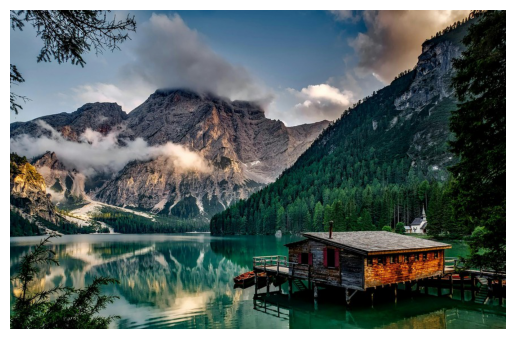

Number of itteration with in_pixels 32
Image after color quantization using K-means:


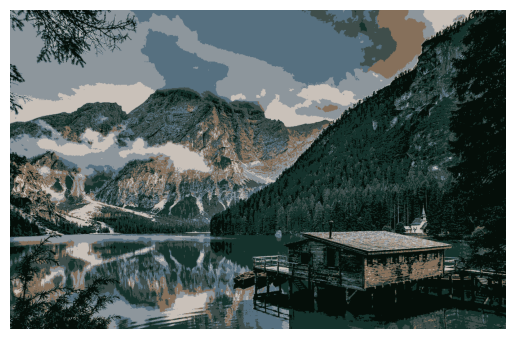

Image saved as: 'landscape-resize_kmeans.png' and 'landscape-resize_kmeans.pdf'


In [20]:
# Call main function
main()